## Investigate diaPipe errors in new AP Pipeline runs

During the 2021 diffim sprint, we encountered frequent `diaPipe` failures where multiple `ra` or `pixelId` values were being sent to the `diaCalculation` method. This always occurred when the DiaObject table was being updated. Chris implemented a fix on DM-28555, so I ran a subset of tract 8913 HSC data through the gen3 AP Pipeline with bps 2x to investigate whether the problem was resolved.

Both of the runs were in the gen3 shared repo `/datasets/hsc/gen3repo/rc2w50_ssw02` and logs were written to `/project/mrawls/diffim_sprint_2021/bps`.

* Control run is with w_2021_09, which has the known diaPipe bug
* Collection is `u/mrawls/ApPipe_smallrun_w202109_bestSeeing`
* APDB is in postgres schema `mrawls_smallrun1_bestSeeing`


* The other run is with ticket branch DM-28555
* Collection is `u/mrawls/ApPipe_smallrun_DM28555_bestSeeing`
* APDB is in postgres schema `mrawls_smallrun2_bestSeeing`

The bugfix appears to have worked!

Finally, we use the latter collection to showcase the new cutout plotting utility.

In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
#import psycopg2

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, MapDiaSourceConfig
from lsst.obs.decam import DarkEnergyCamera
from lsst.pipe.base import Struct

### Load functions from ap_pipe-notebooks repo

You need access to both the shared HSC repo and the postgres APDB land

In [2]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [3]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

<module 'coaddAnalysis' from '/project/mrawls/ap_pipe-notebooks/coaddAnalysis.py'>

### Set repo, butler, and collections

In [4]:
repo = '/datasets/hsc/gen3repo/rc2w50_ssw02'

In [5]:
butler = dafButler.Butler(repo)

In [6]:
collections_control = 'u/mrawls/ApPipe_smallrun_w202109_bestSeeing'
collections_DM28555 = 'u/mrawls/ApPipe_smallrun_DM28555_bestSeeing'

### Experiment with different flags here!

In [7]:
# option to change badFlagList
# (defaults are the first 3)
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
              ]
               #'base_PixelFlags_flag_interpolatedCenter',
               #'base_PixelFlags_flag_edge']

# Control first

In [8]:
schema = 'mrawls_smallrun1_bestSeeing' 
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=schema,
                                                      gen='gen3',
                                                      instrument='HSC')

In [9]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3', instrument='HSC',
                                                                               repo=repo)

<IPython.core.display.Javascript object>


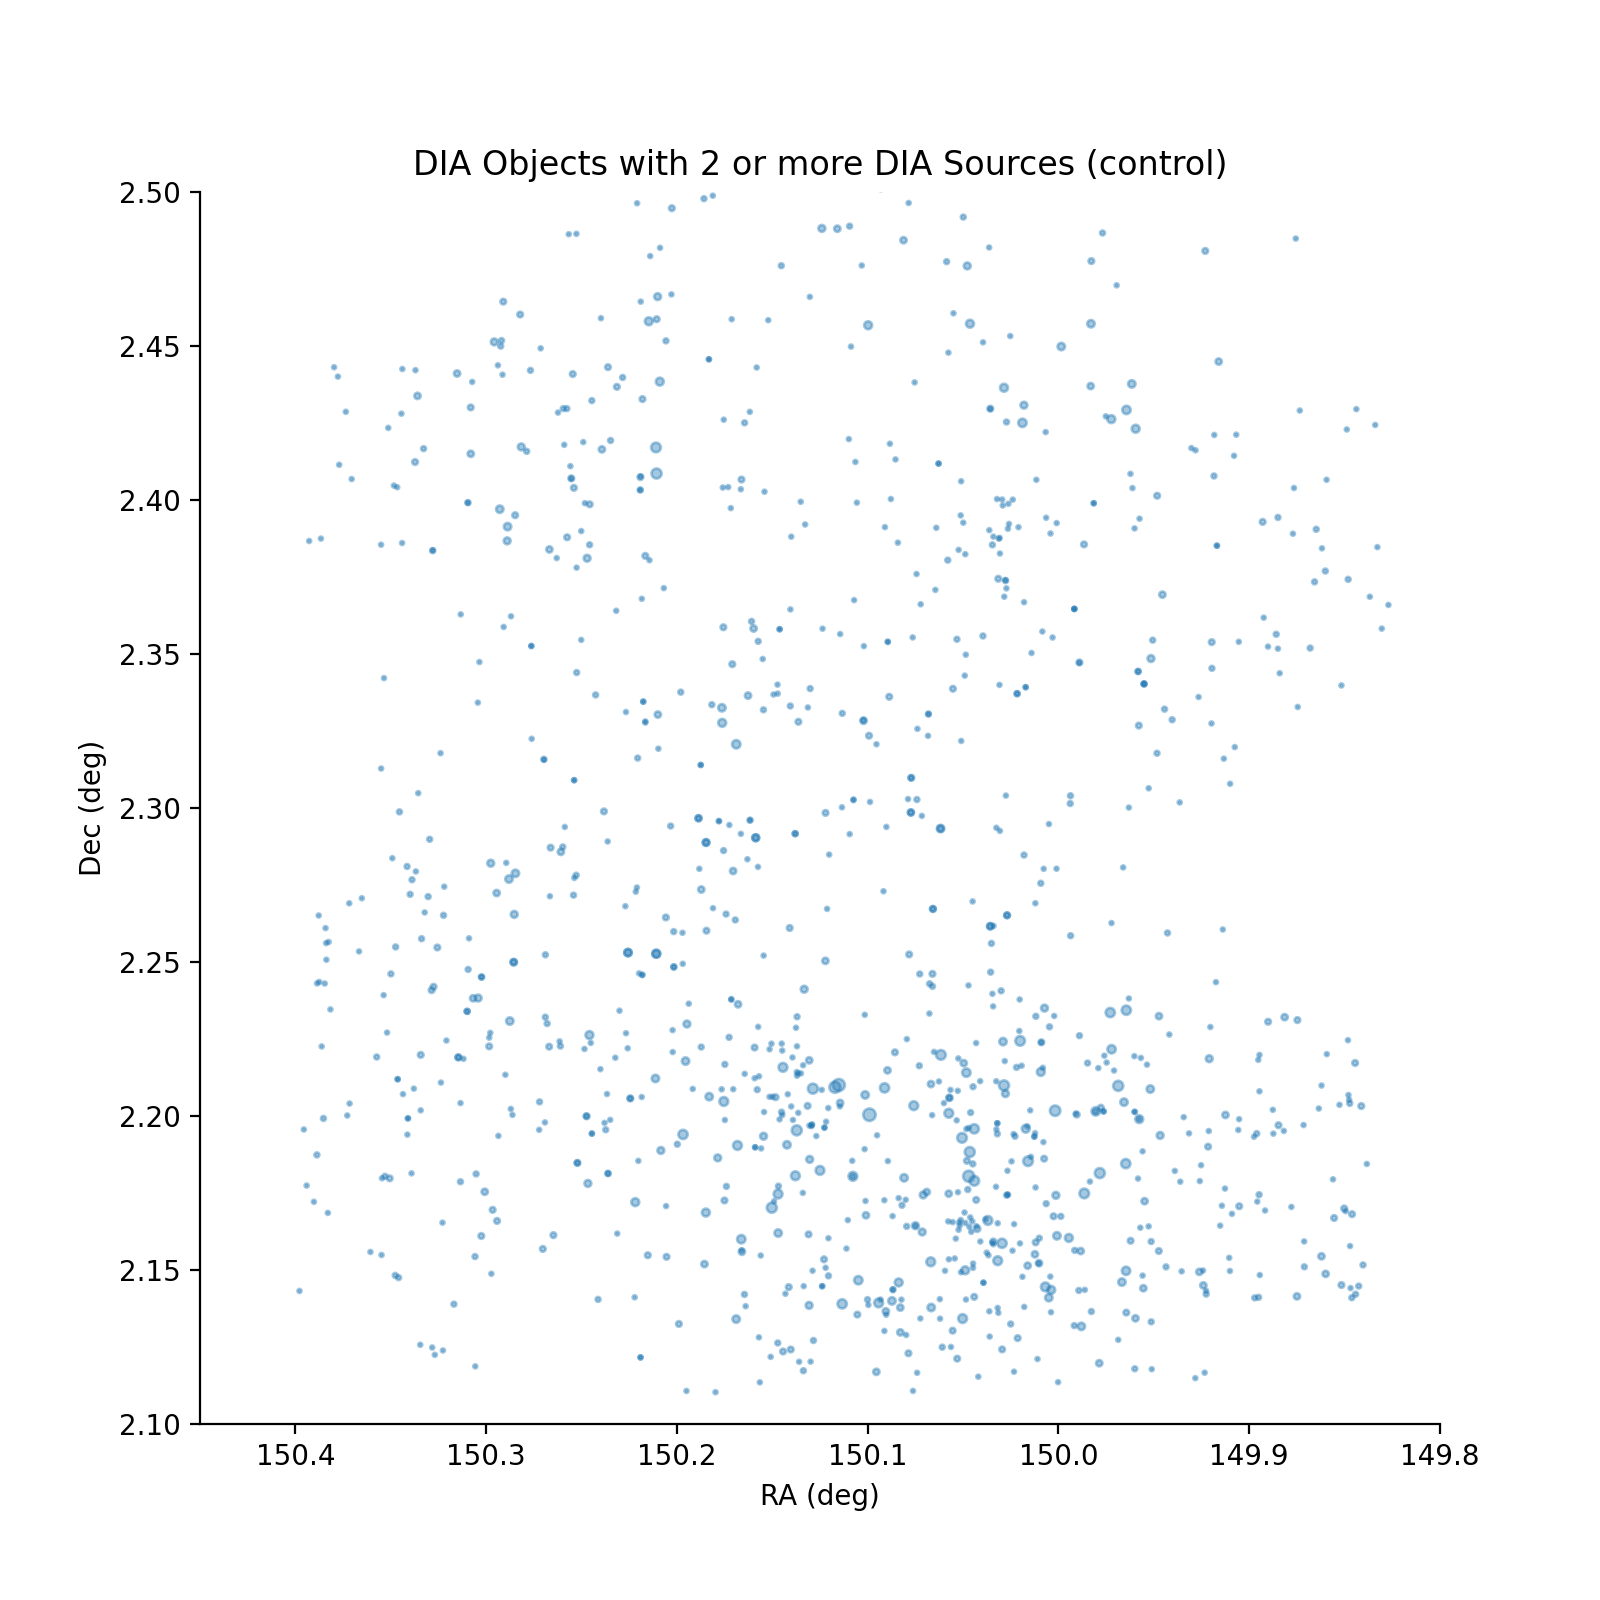

Text(0.5, 1.0, 'DIA Objects with 2 or more DIA Sources (control)')

In [10]:
fig = plt.figure(figsize=(8,8))

# whole field
#xlim = (151.05, 149.40)
#ylim = (1.45, 3.03)

# subset region
xlim = (150.45, 149.8)
ylim = (2.1, 2.5)
cutoff = 1  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('DIA Objects with 2 or more DIA Sources (control)')

<IPython.core.display.Javascript object>


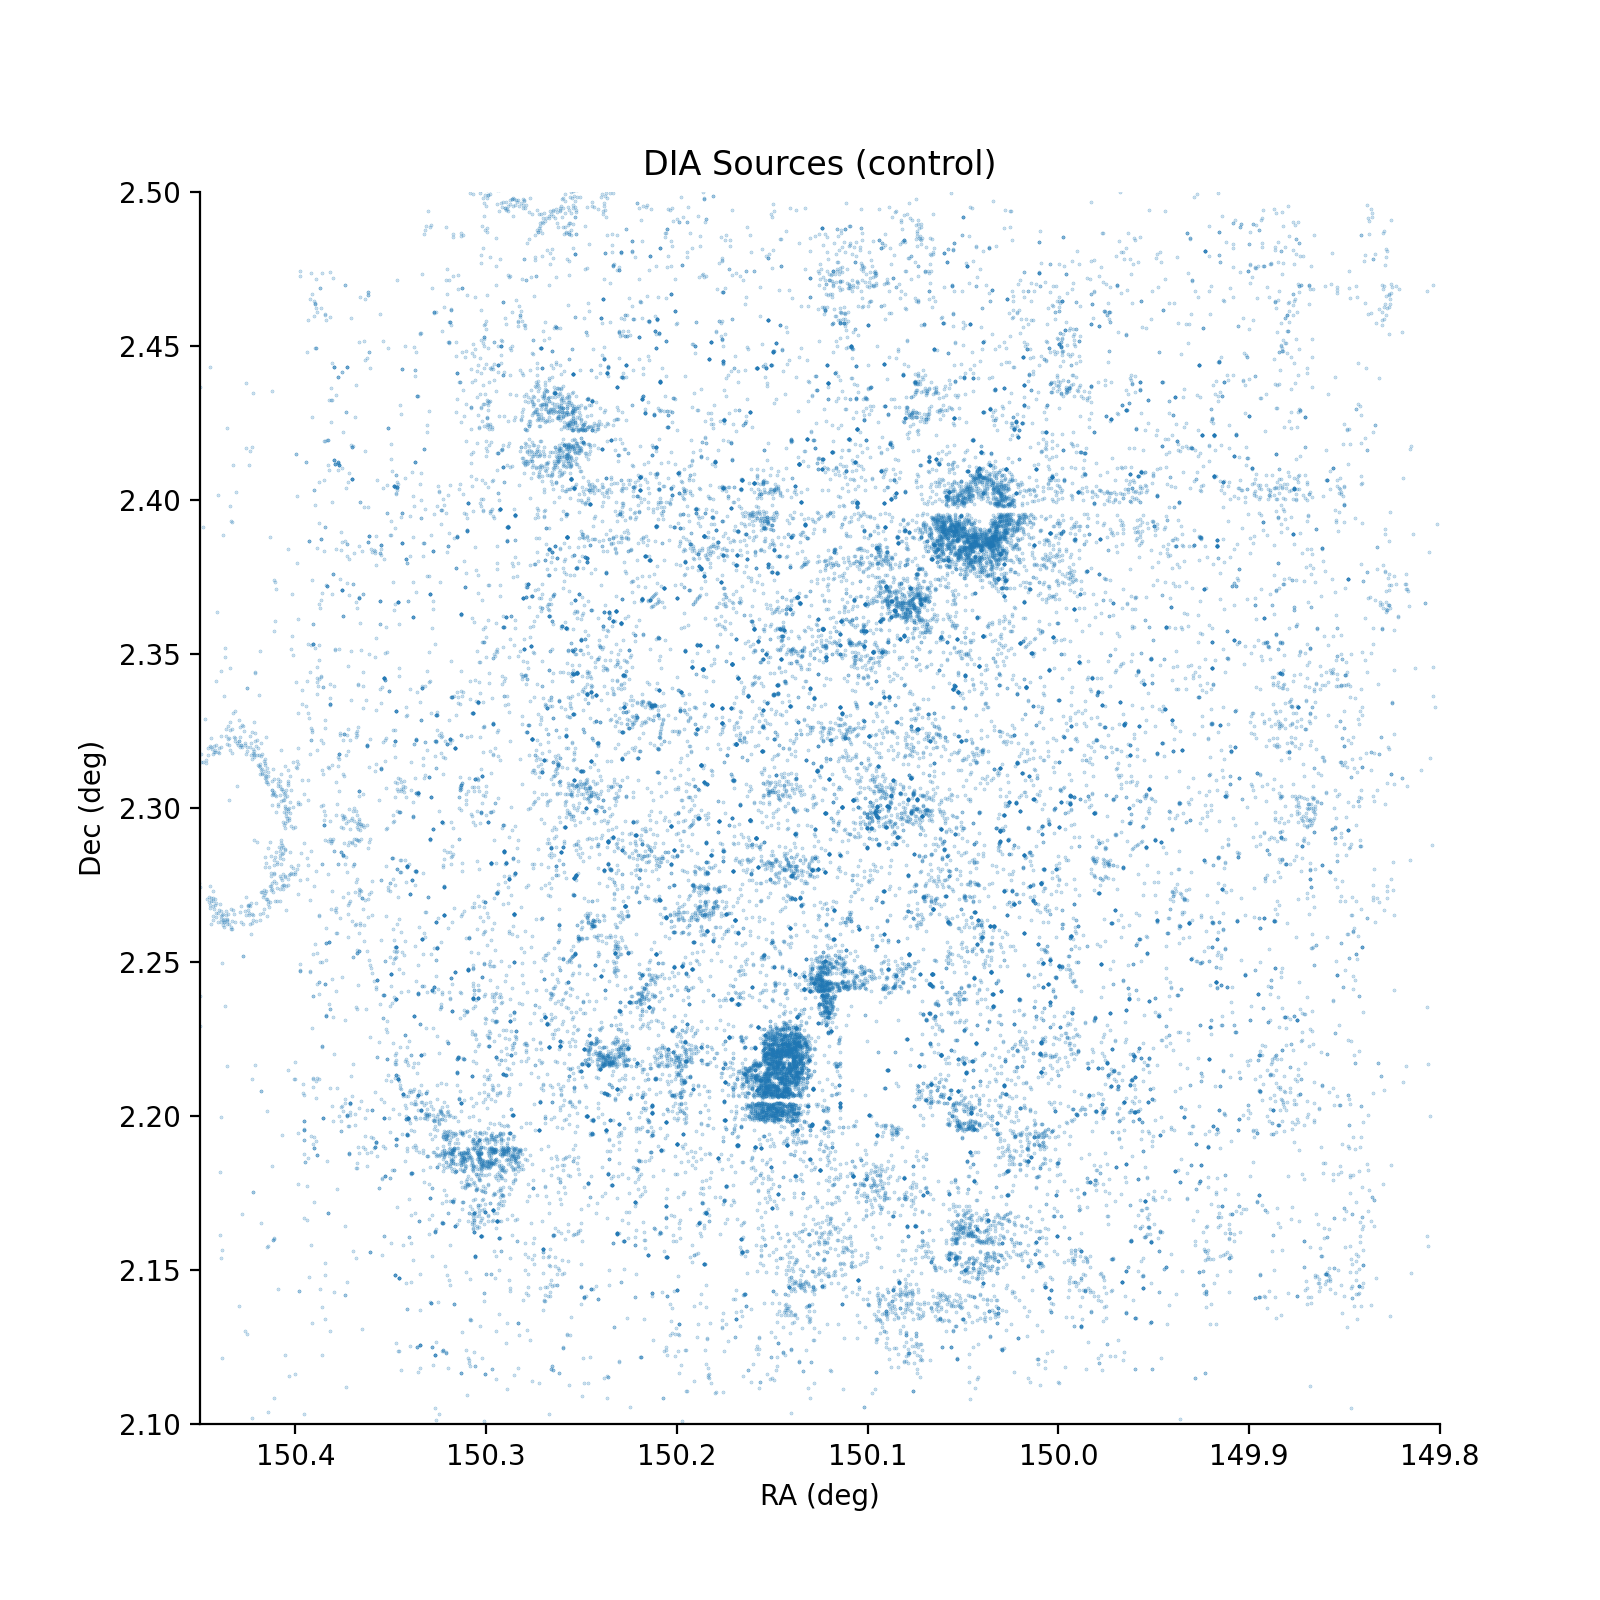

Text(0.5, 1.0, 'DIA Sources (control)')

In [11]:
fig = plt.figure(figsize=(8,8))

xlim = (150.45, 149.8)
ylim = (2.1, 2.5)

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodSrc['ra'], goodSrc['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('DIA Sources (control)')

<IPython.core.display.Javascript object>


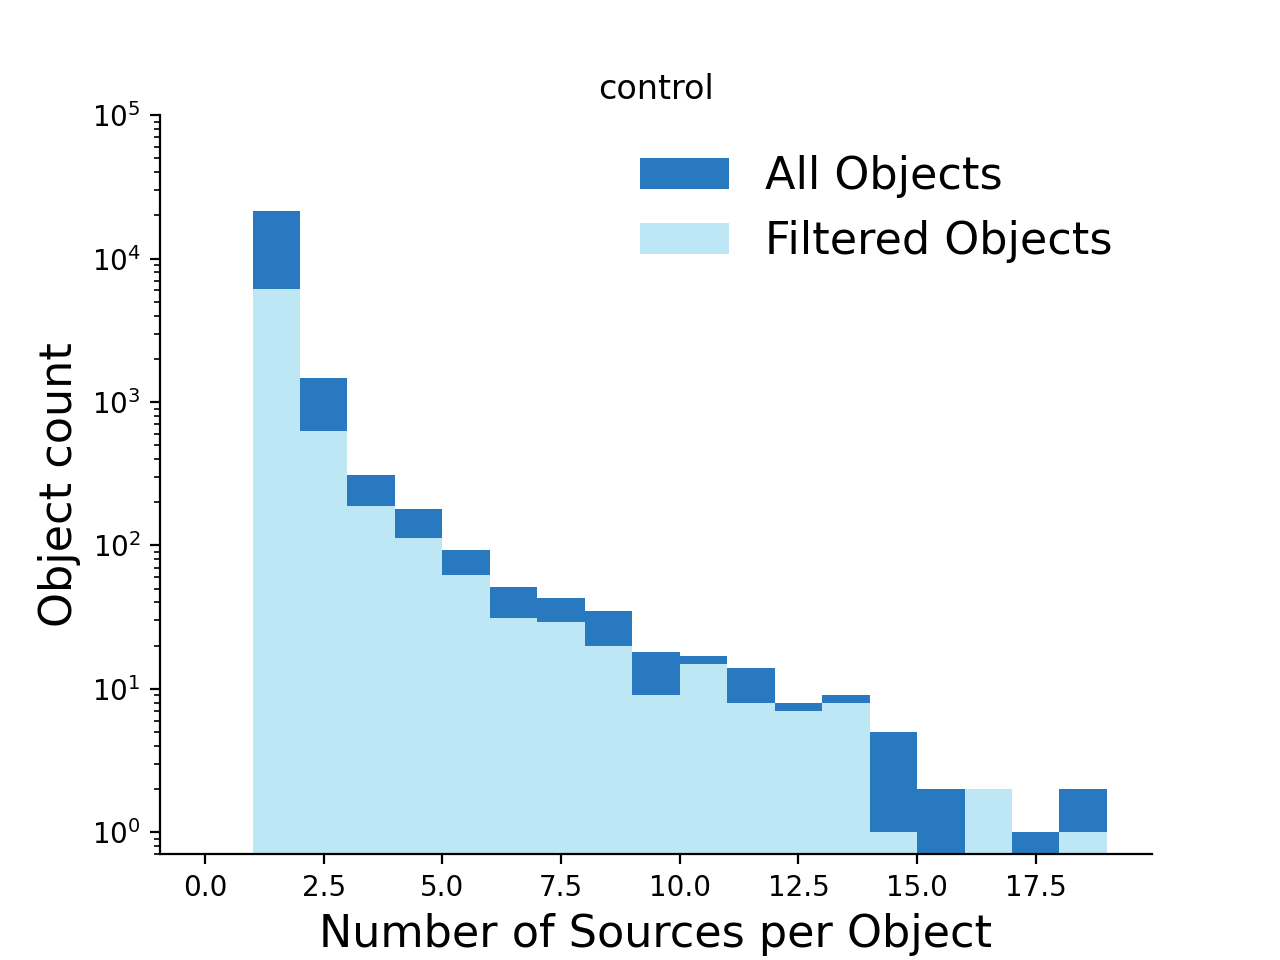

In [12]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj, title='control')

<IPython.core.display.Javascript object>


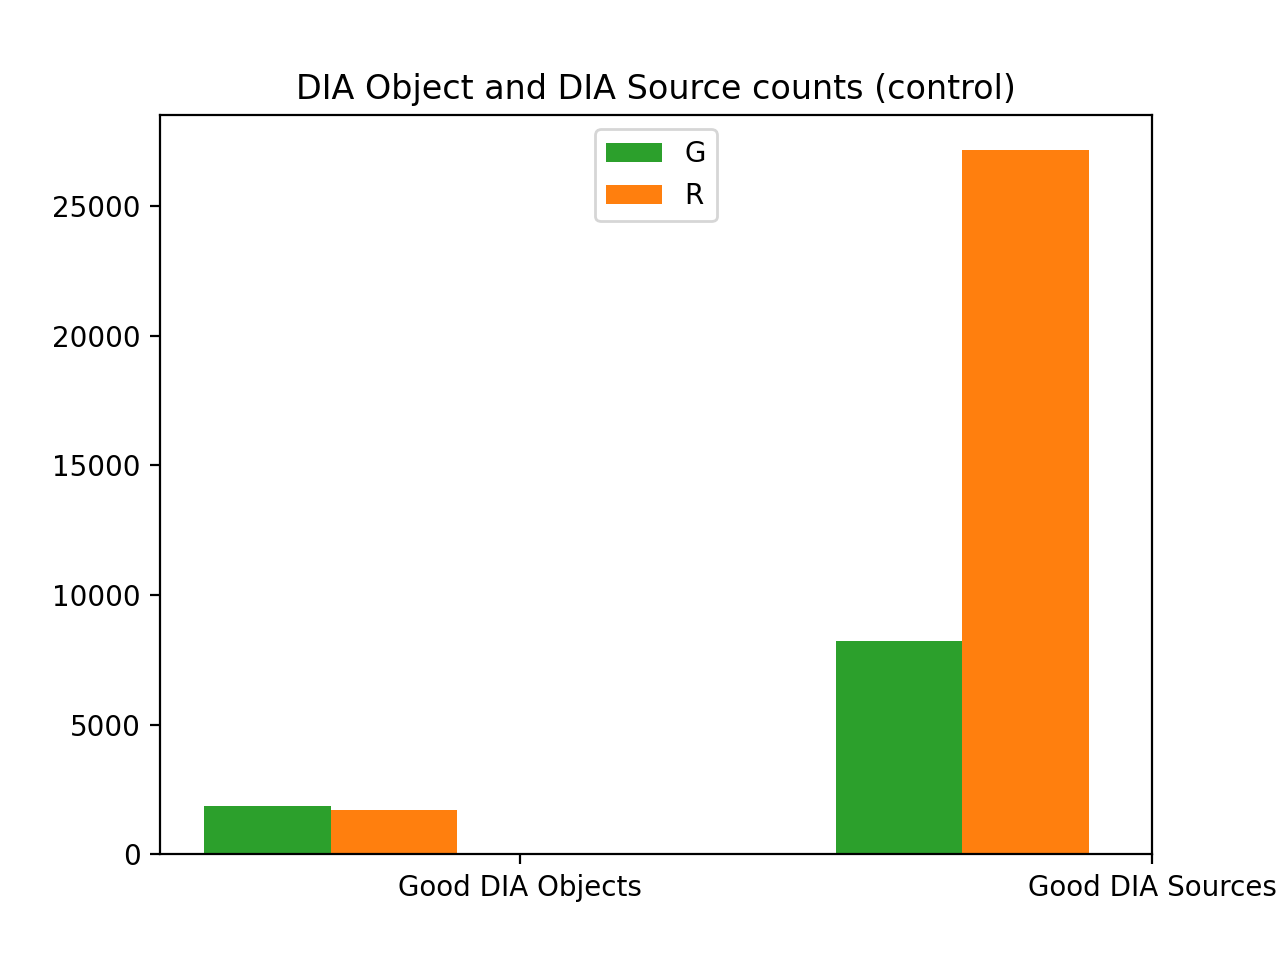

Text(0.5, 1.0, 'DIA Object and DIA Source counts (control)')

In [13]:
fig, ax = plt.subplots()
barLabels = ['Good DIA Objects', 'Good DIA Sources']
xbar = np.array([0, 1])
width = 0.4

goodObjG = goodObj.loc[goodObj['gPSFluxMean'] > 0]
goodObjR = goodObj.loc[goodObj['rPSFluxMean'] > 0]

goodSrcG = goodSrc.loc[goodSrc['filterName'] == 'g']
goodSrcR = goodSrc.loc[goodSrc['filterName'] == 'r']

ax.bar(xbar - width, [len(goodObjG), len(goodSrcG)], width/2, label='G', color='C2')
ax.bar(xbar - width/2, [len(goodObjR), len(goodSrcR)], width/2, label='R', color='C1')

plt.legend(loc='upper center')
ax.set_xticks([0, 1])
labels = ax.set_xticklabels(barLabels)
plt.title('DIA Object and DIA Source counts (control)')

# DM-28555 next

In [14]:
schema2 = 'mrawls_smallrun2_bestSeeing' 
objTable2, srcTable2, goodObj2, goodSrc2 = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName='lsstdevapdb1',
                                                          schema=schema2,
                                                          instrument='HSC',
                                                          gen='gen3')

In [15]:
srcTable2 = pla.addVisitCcdToSrcTable(srcTable2, instrument='HSC', gen='gen3', butler=butler)
flagTable2, srcTableFlags2, flagFilter2, goodSrc2, goodObj2 = pla.makeSrcTableFlags(srcTable2, objTable2,
                                                                                    gen='gen3', instrument='HSC',
                                                                                    repo=repo,
                                                                                    badFlagList=badFlagList)

In [16]:
# Experimenting with setting the sourceID as the index
#srcTable2.set_index("diaSourceId", inplace=True)
#goodSrc2.set_index("diaSourceId", inplace=True)

<IPython.core.display.Javascript object>


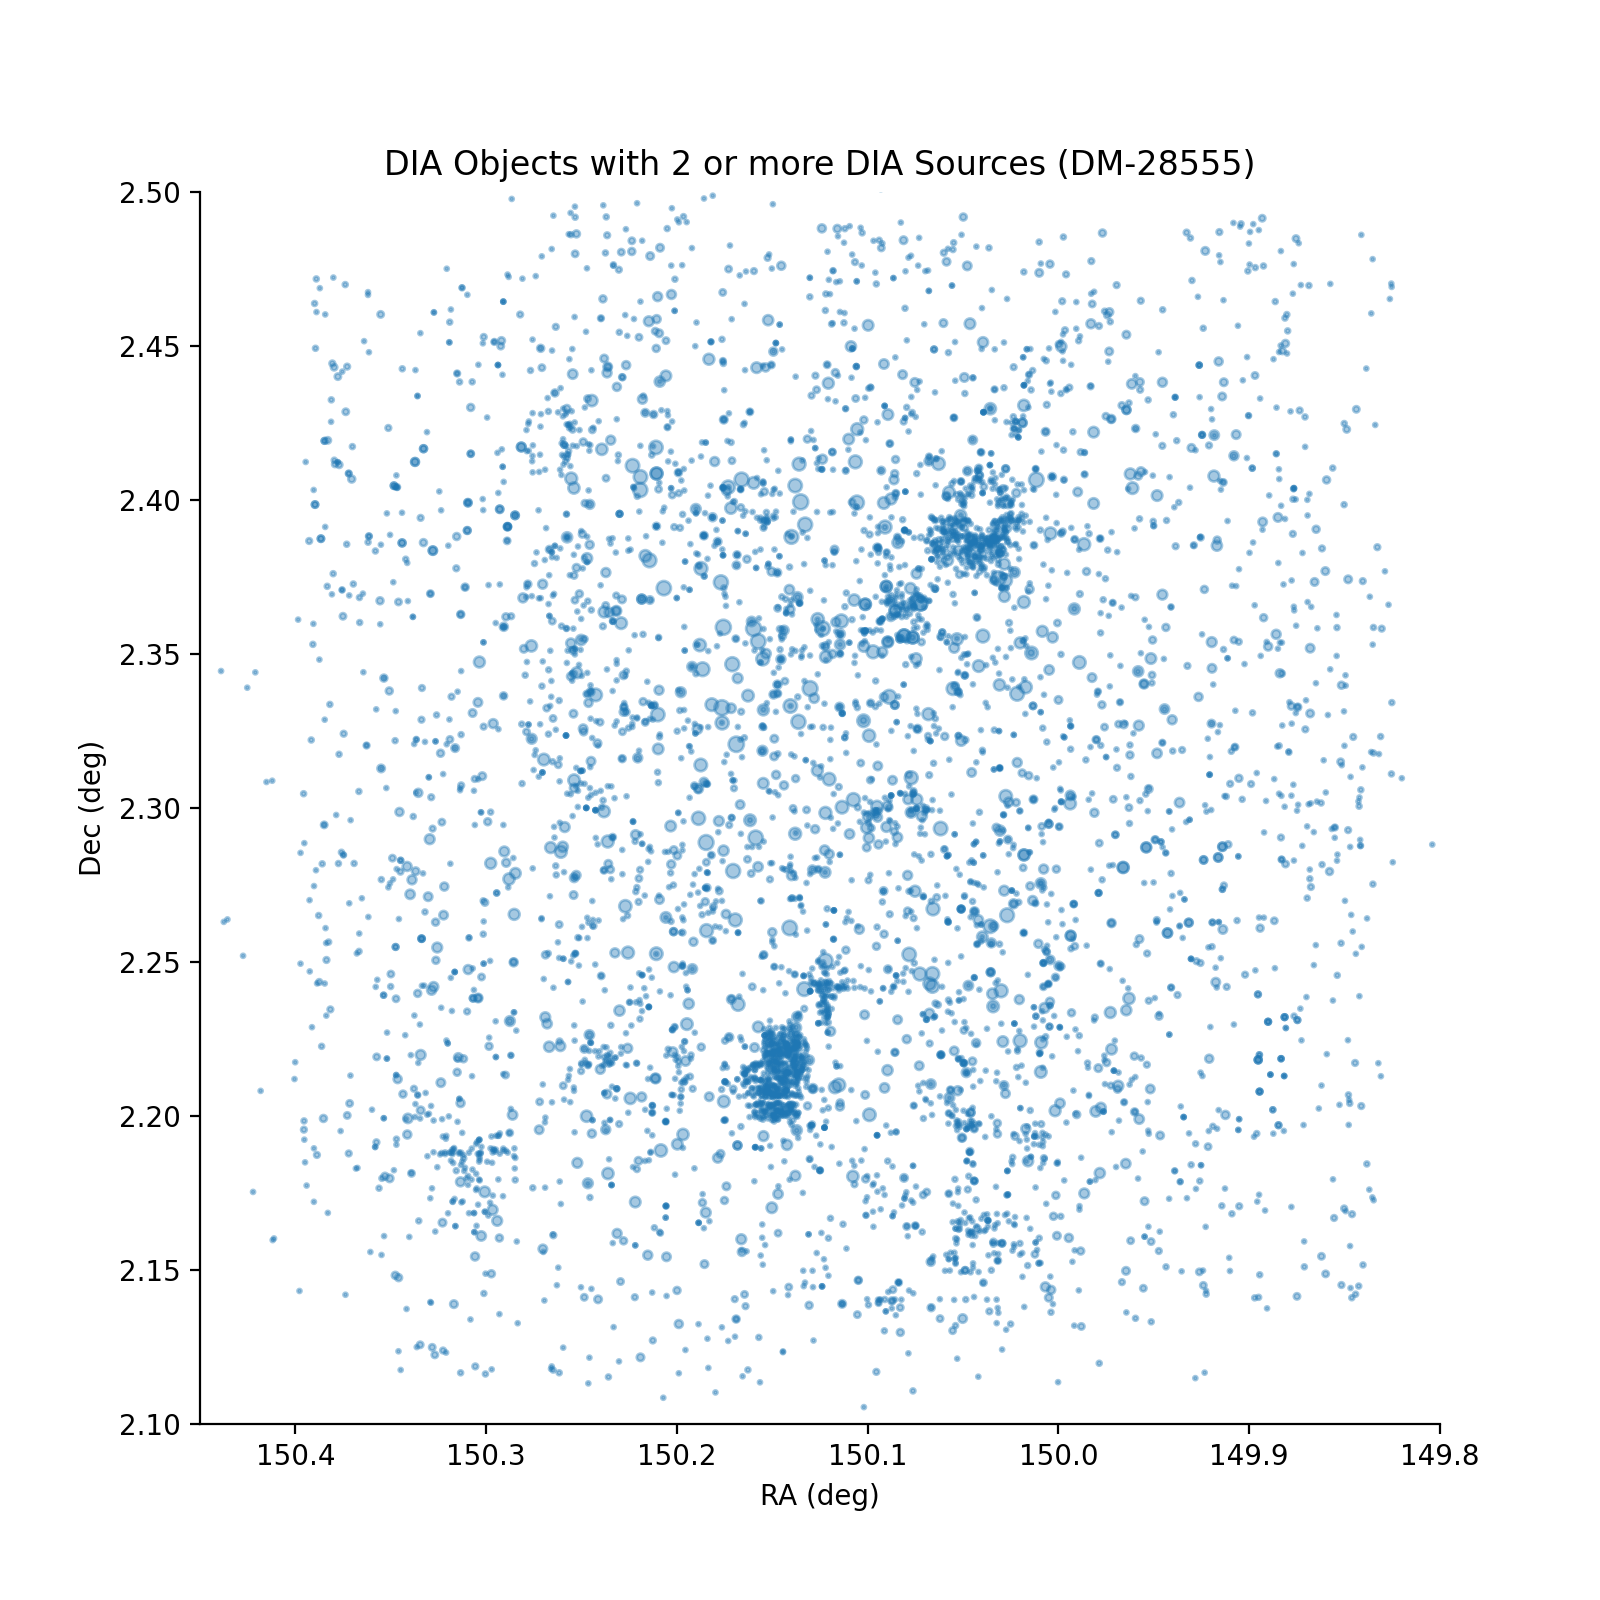

Text(0.5, 1.0, 'DIA Objects with 2 or more DIA Sources (DM-28555)')

In [17]:
fig = plt.figure(figsize=(8,8))

# whole field
#xlim = (151.05, 149.40)
#ylim = (1.45, 3.03)

# subset region
xlim = (150.45, 149.8)
ylim = (2.1, 2.5)
cutoff = 1  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj2.loc[goodObj2['nDiaSources'] > cutoff, 'ra'], goodObj2.loc[goodObj2['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj2.loc[goodObj2['nDiaSources'] > cutoff, 'nDiaSources'], marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('DIA Objects with 2 or more DIA Sources (DM-28555)')

<IPython.core.display.Javascript object>


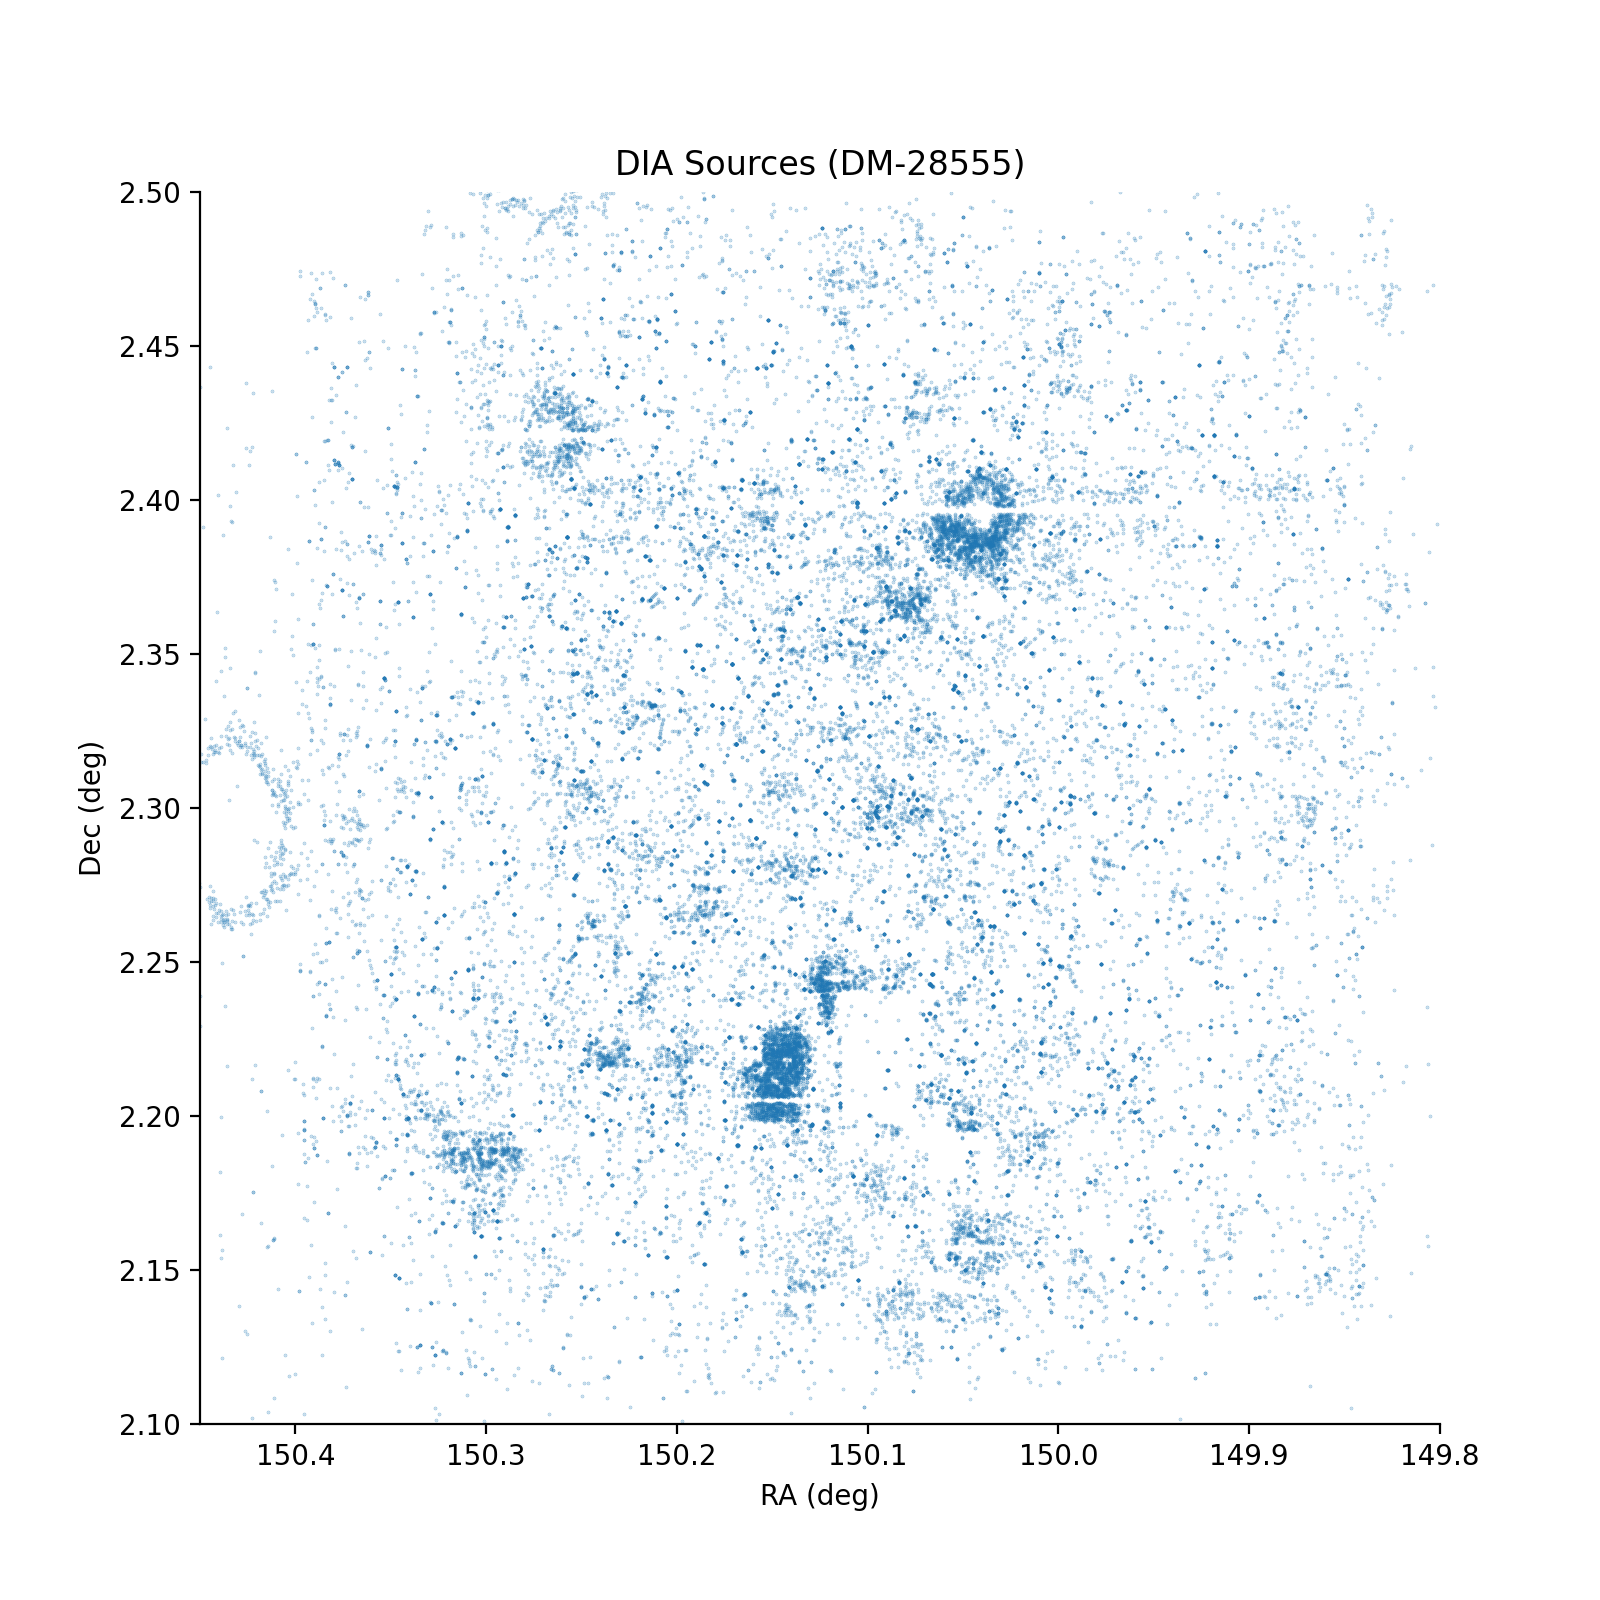

Text(0.5, 1.0, 'DIA Sources (DM-28555)')

In [18]:
fig = plt.figure(figsize=(8,8))

xlim = (150.45, 149.8)
ylim = (2.1, 2.5)

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodSrc2['ra'], goodSrc2['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('DIA Sources (DM-28555)')

<IPython.core.display.Javascript object>


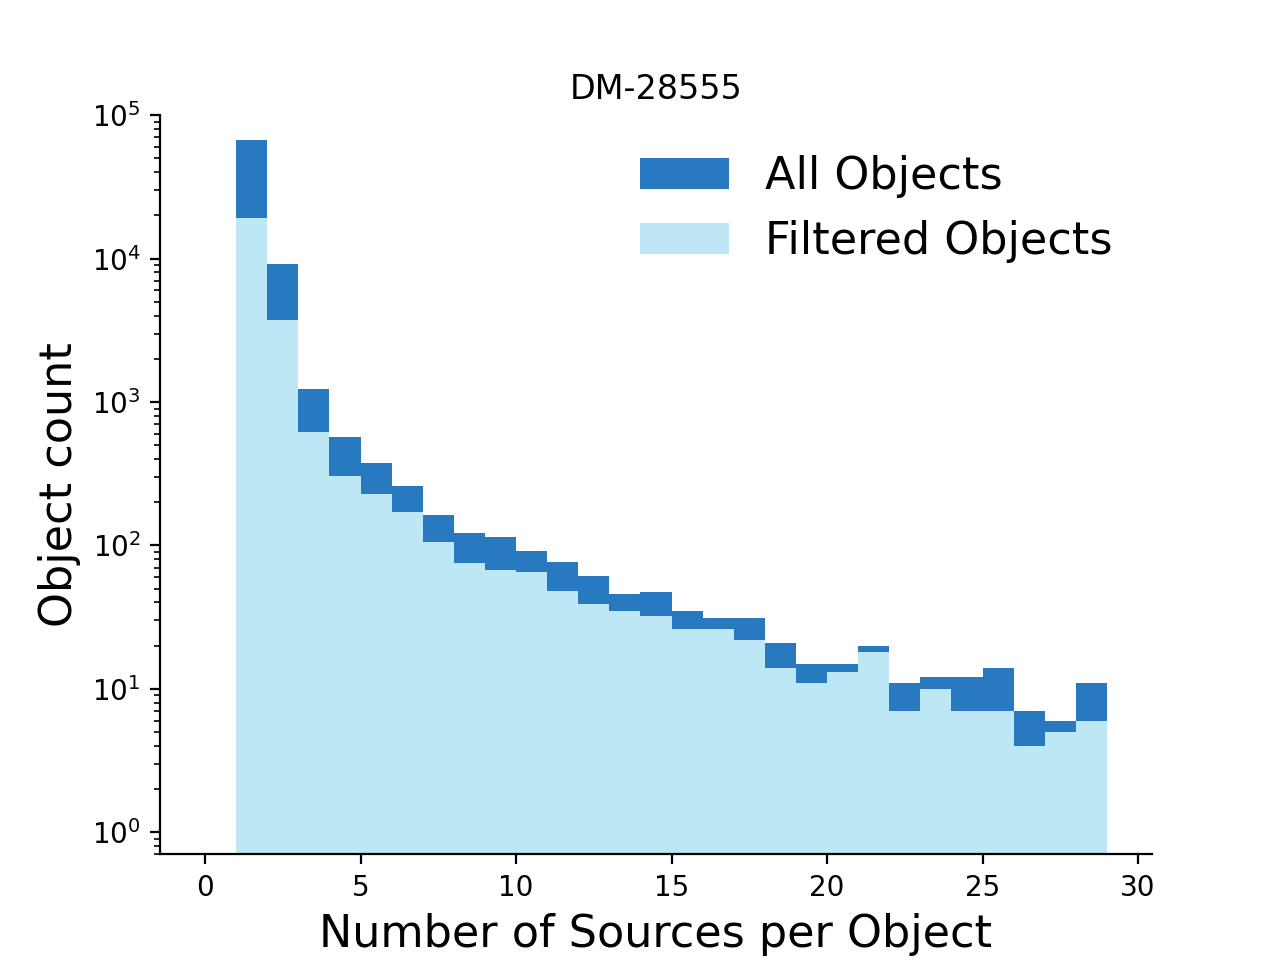

In [19]:
hist = doa.plotDiaObjectHistogram(objTable2, goodObj2, title='DM-28555')

<IPython.core.display.Javascript object>


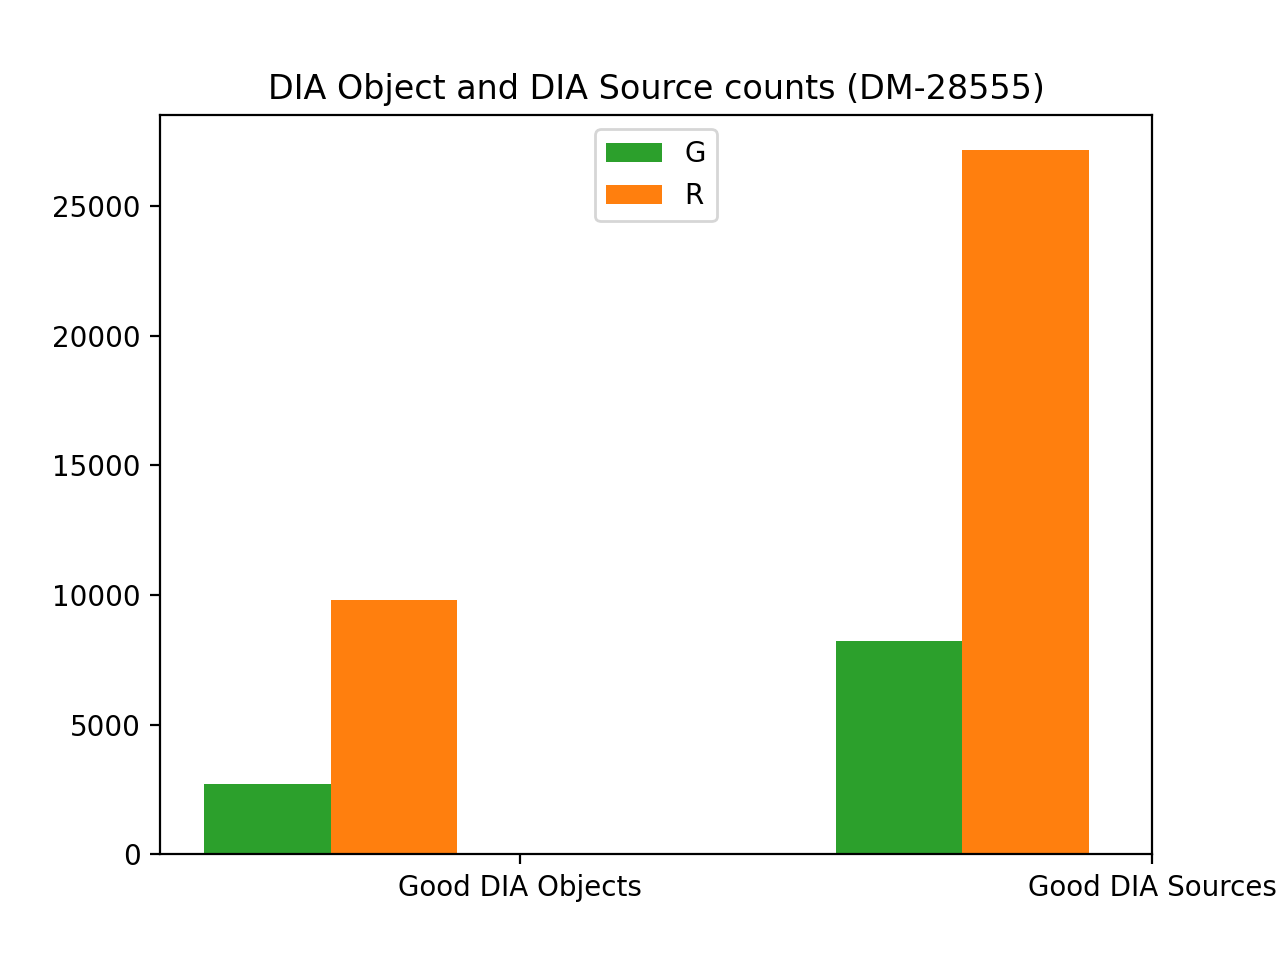

Text(0.5, 1.0, 'DIA Object and DIA Source counts (DM-28555)')

In [20]:
fig, ax = plt.subplots()
barLabels = ['Good DIA Objects', 'Good DIA Sources']
xbar = np.array([0, 1])
width = 0.4

goodObjG = goodObj2.loc[goodObj2['gPSFluxMean'] > 0]
goodObjR = goodObj2.loc[goodObj2['rPSFluxMean'] > 0]

goodSrcG = goodSrc2.loc[goodSrc2['filterName'] == 'g']
goodSrcR = goodSrc2.loc[goodSrc2['filterName'] == 'r']

ax.bar(xbar - width, [len(goodObjG), len(goodSrcG)], width/2, label='G', color='C2')
ax.bar(xbar - width/2, [len(goodObjR), len(goodSrcR)], width/2, label='R', color='C1')

plt.legend(loc='upper center')
ax.set_xticks([0, 1])
labels = ax.set_xticklabels(barLabels)
plt.title('DIA Object and DIA Source counts (DM-28555)')

In [21]:
print(len(srcTable), len(srcTable2))

112309 112309


In [22]:
print(len(objTable), len(objTable2))

23702 79785


## Showcase the new cutout utility

<IPython.core.display.Javascript object>


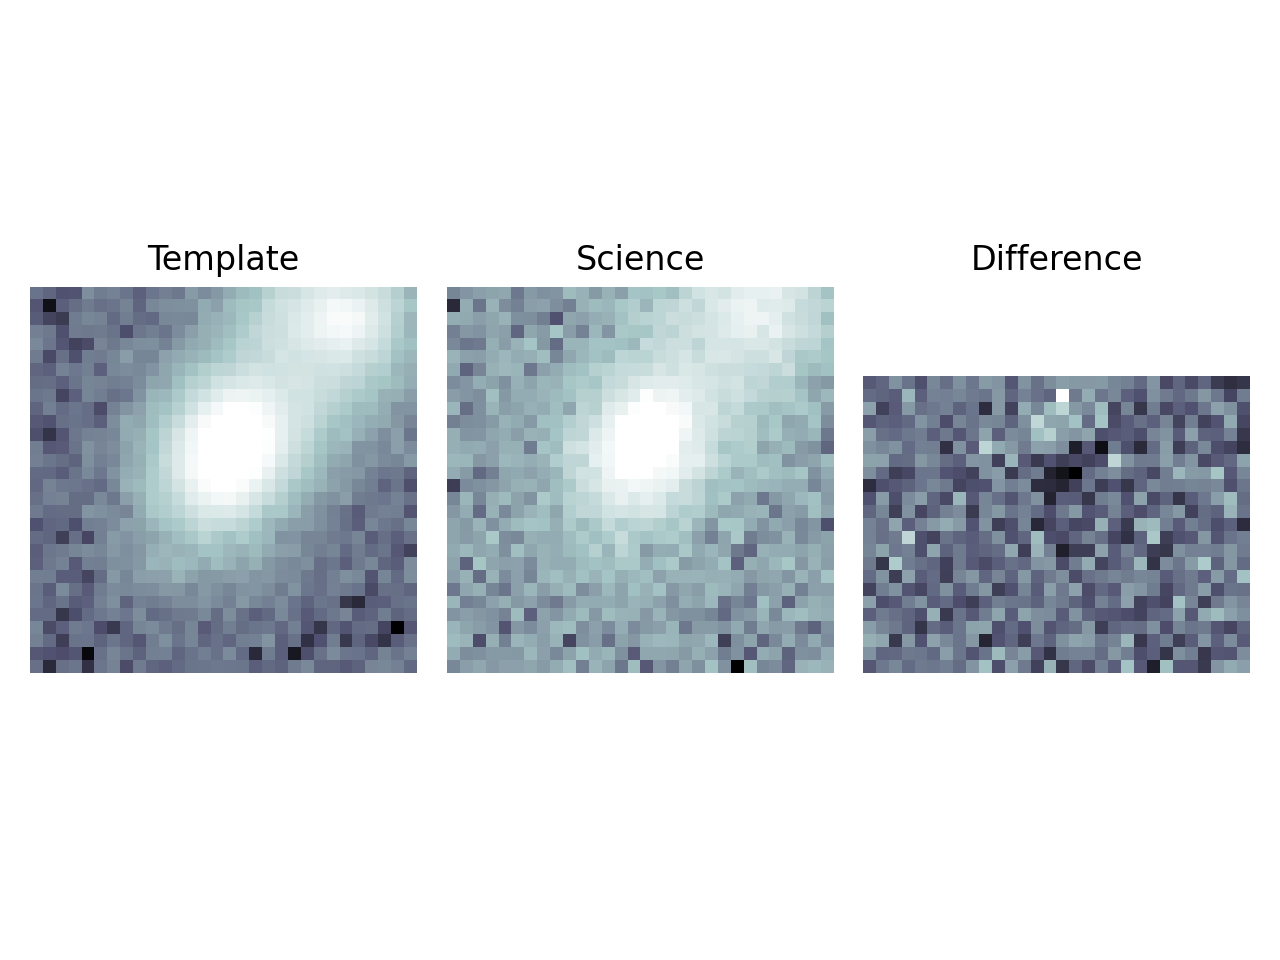

<IPython.core.display.Javascript object>


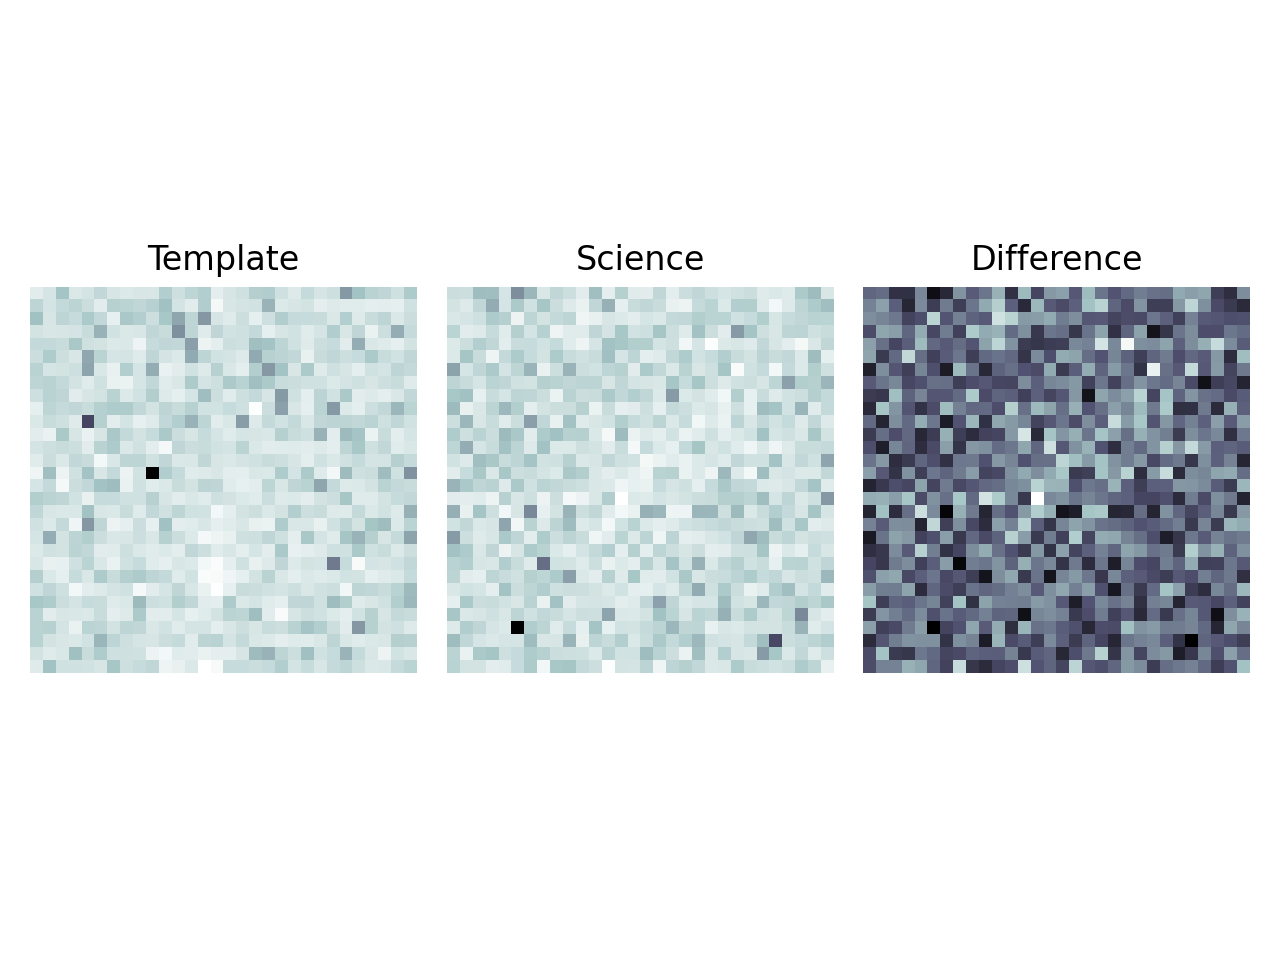

<IPython.core.display.Javascript object>


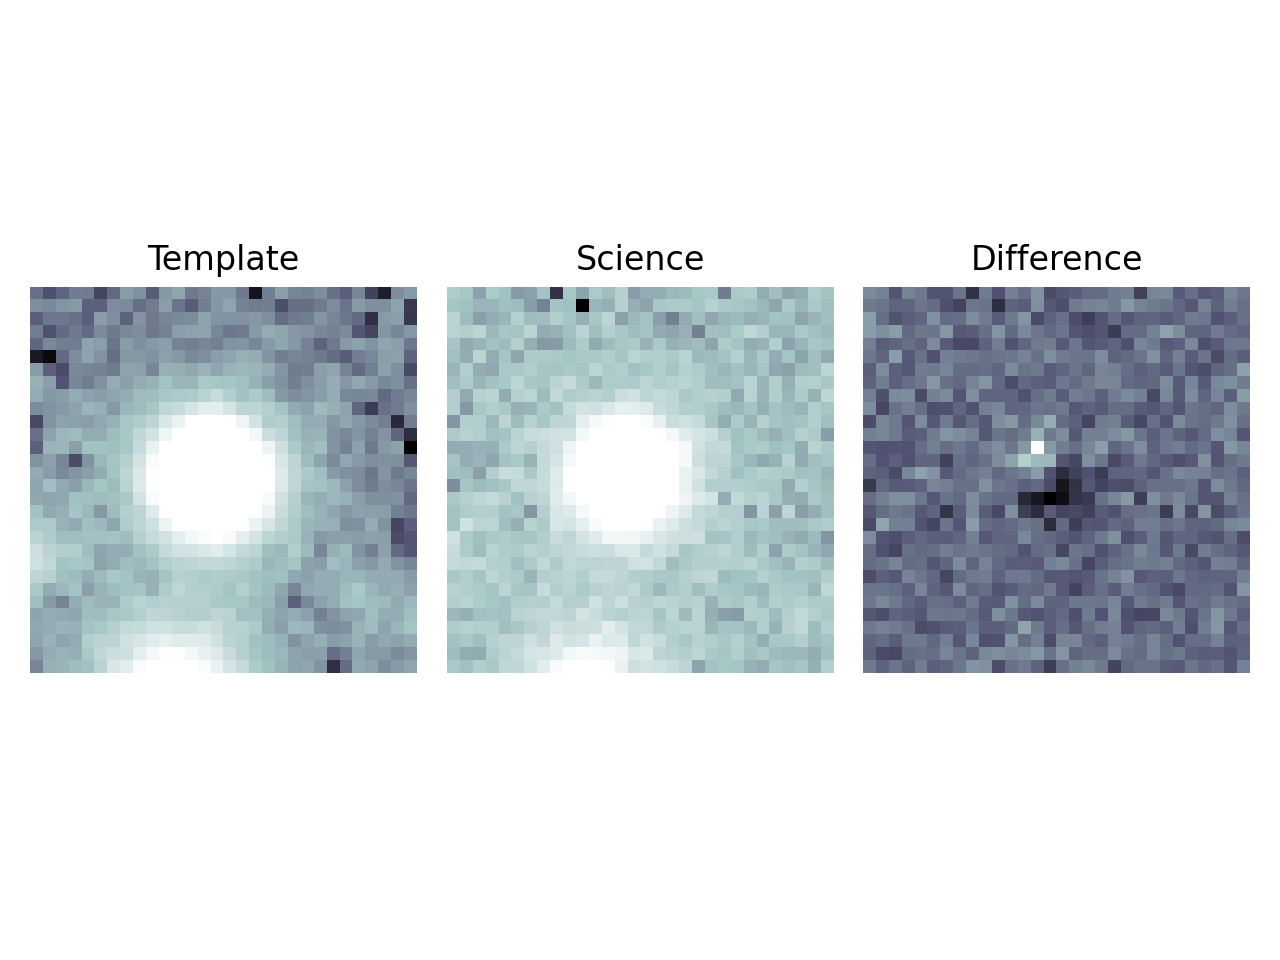

<IPython.core.display.Javascript object>


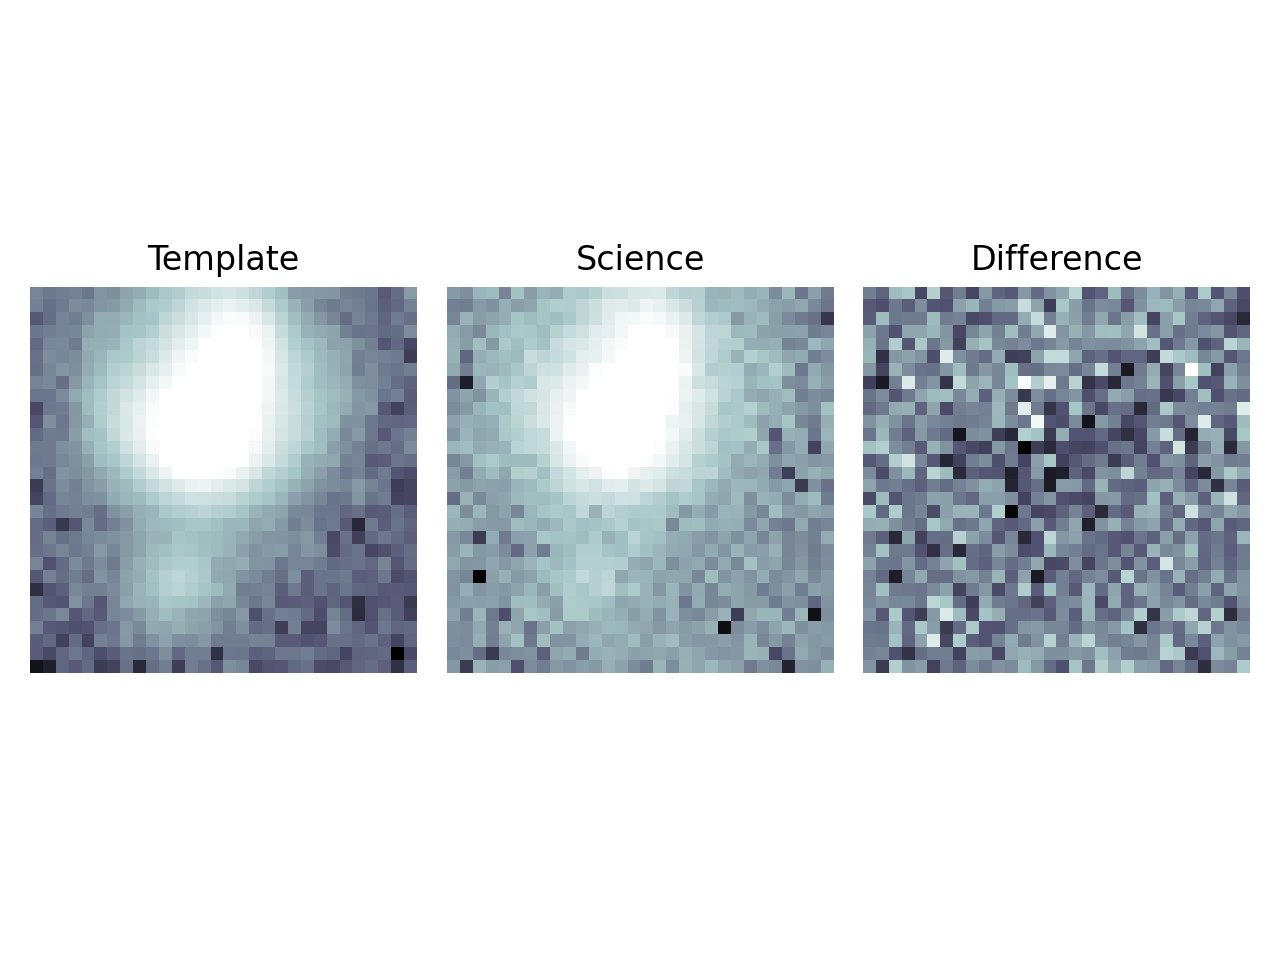

<IPython.core.display.Javascript object>


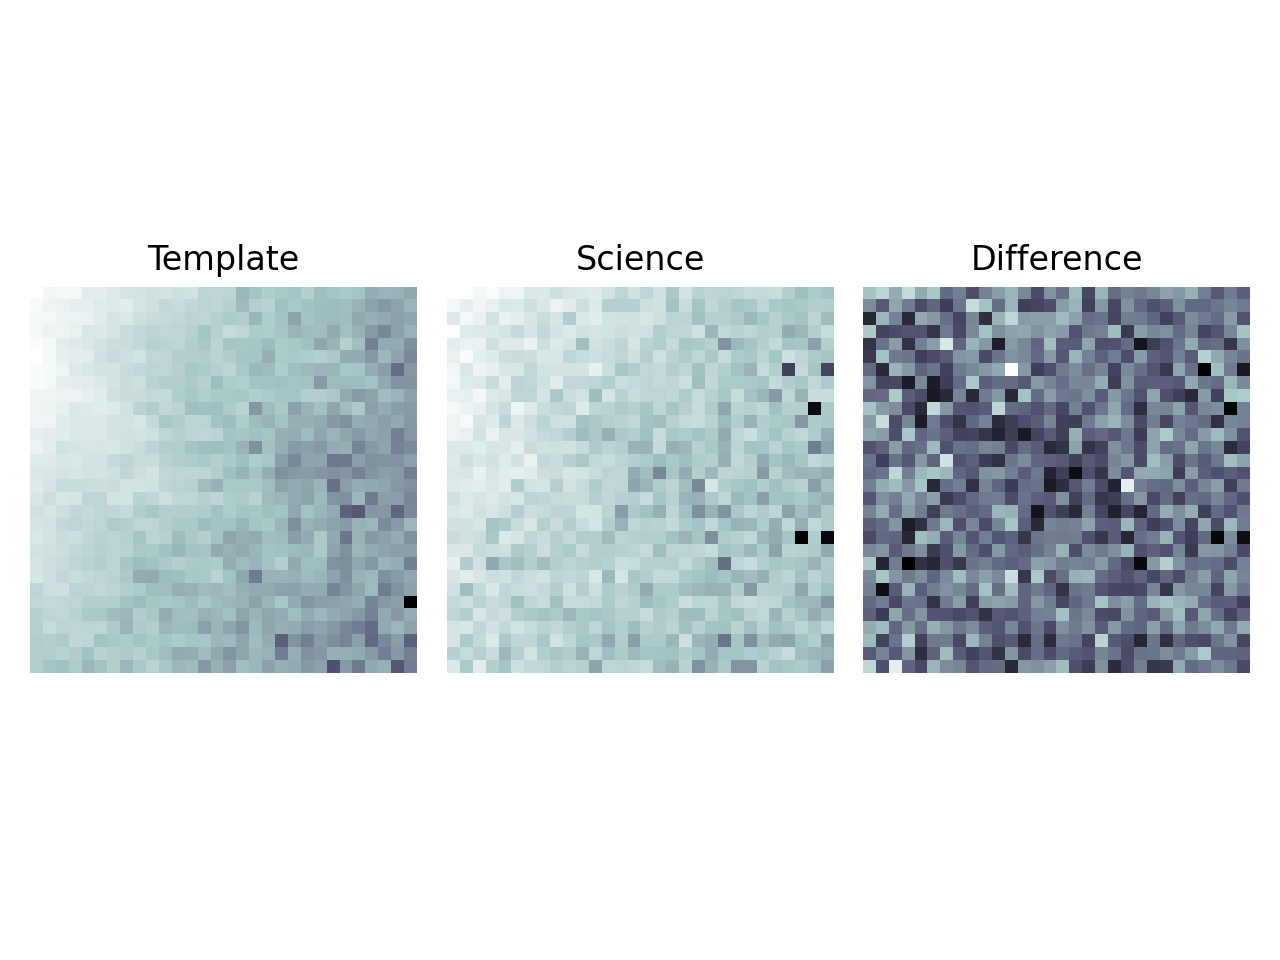

<IPython.core.display.Javascript object>


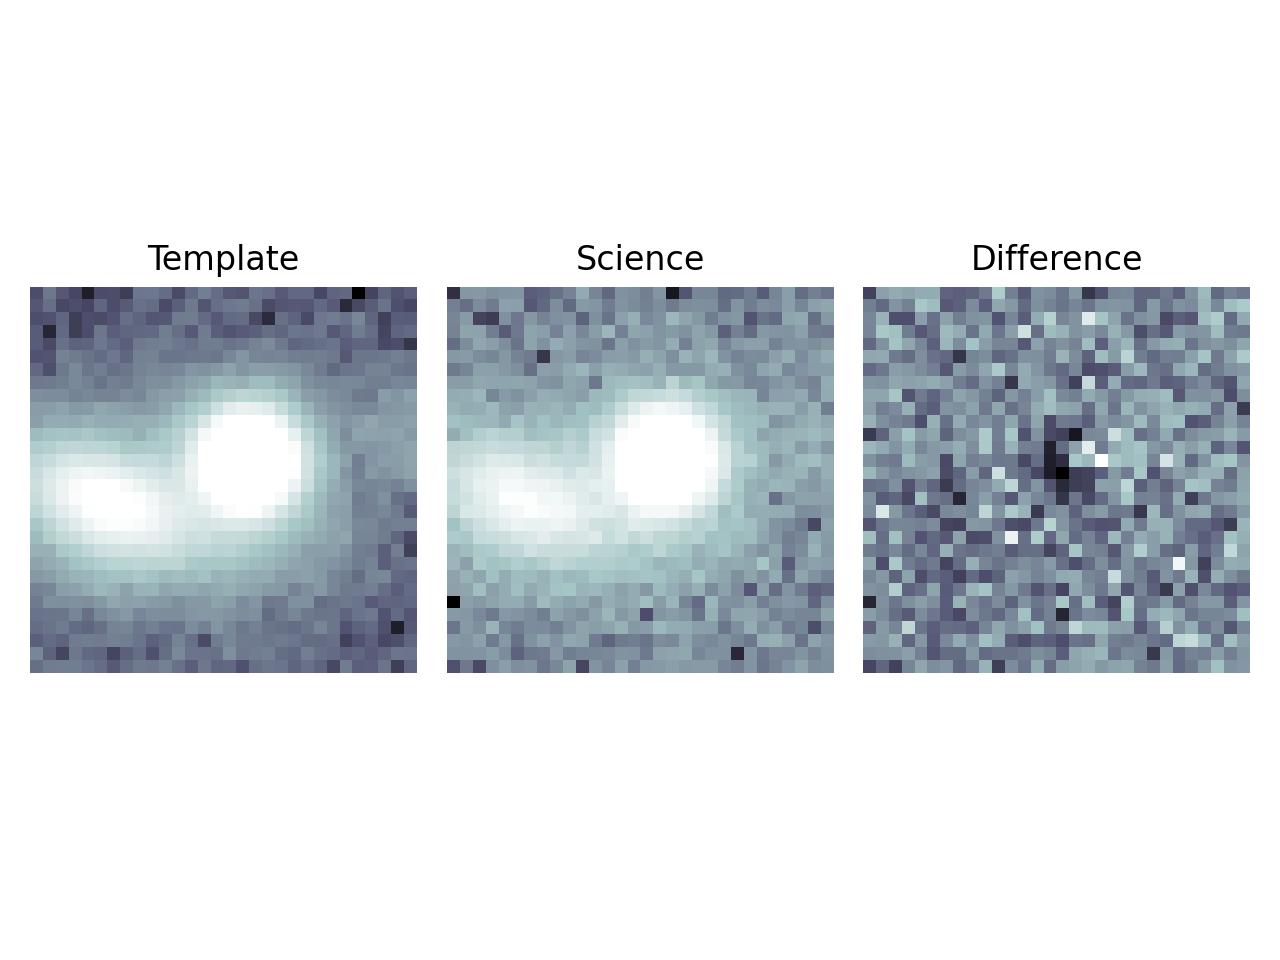

<IPython.core.display.Javascript object>


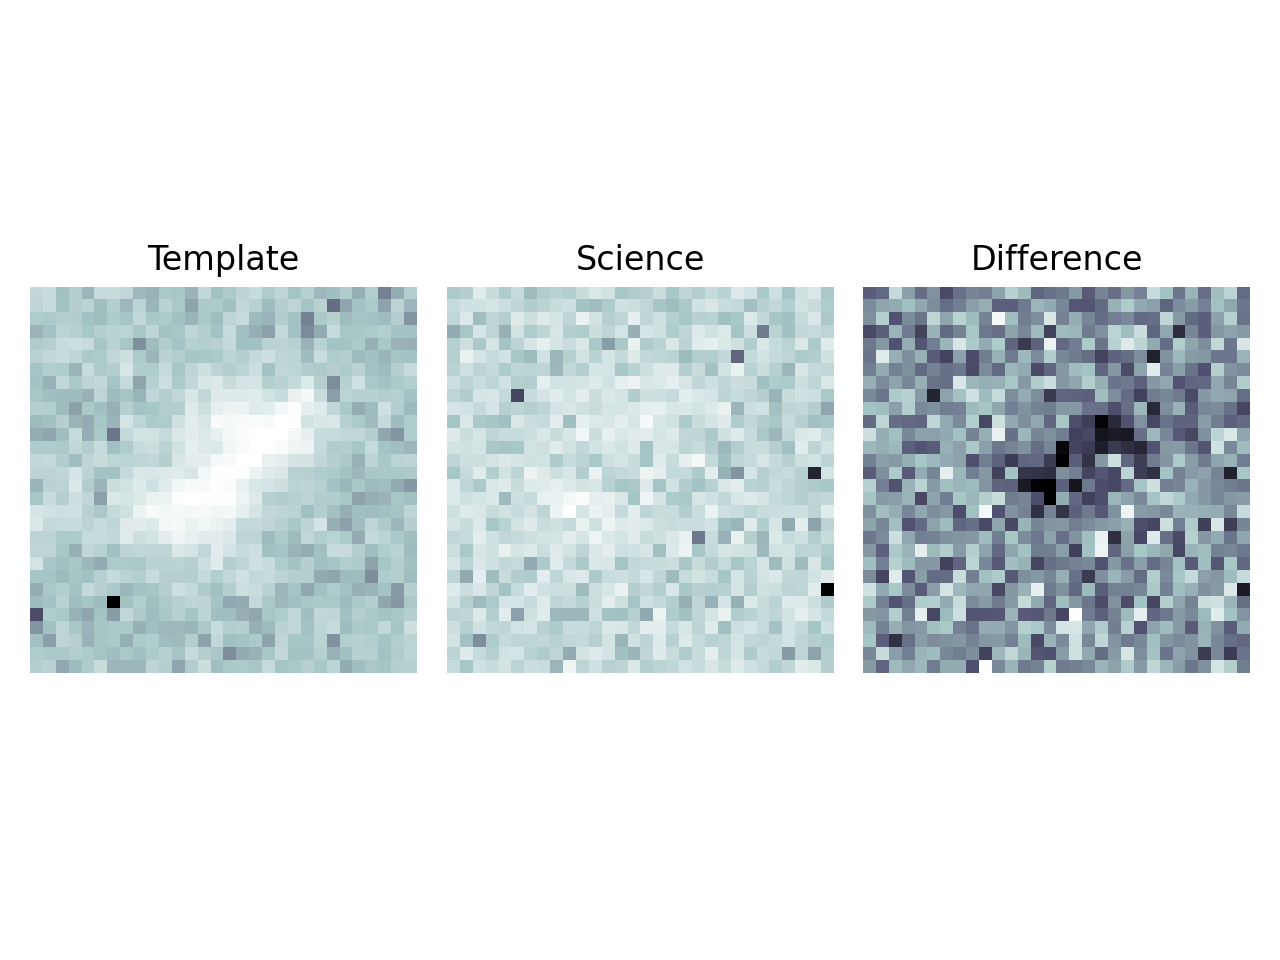

<IPython.core.display.Javascript object>


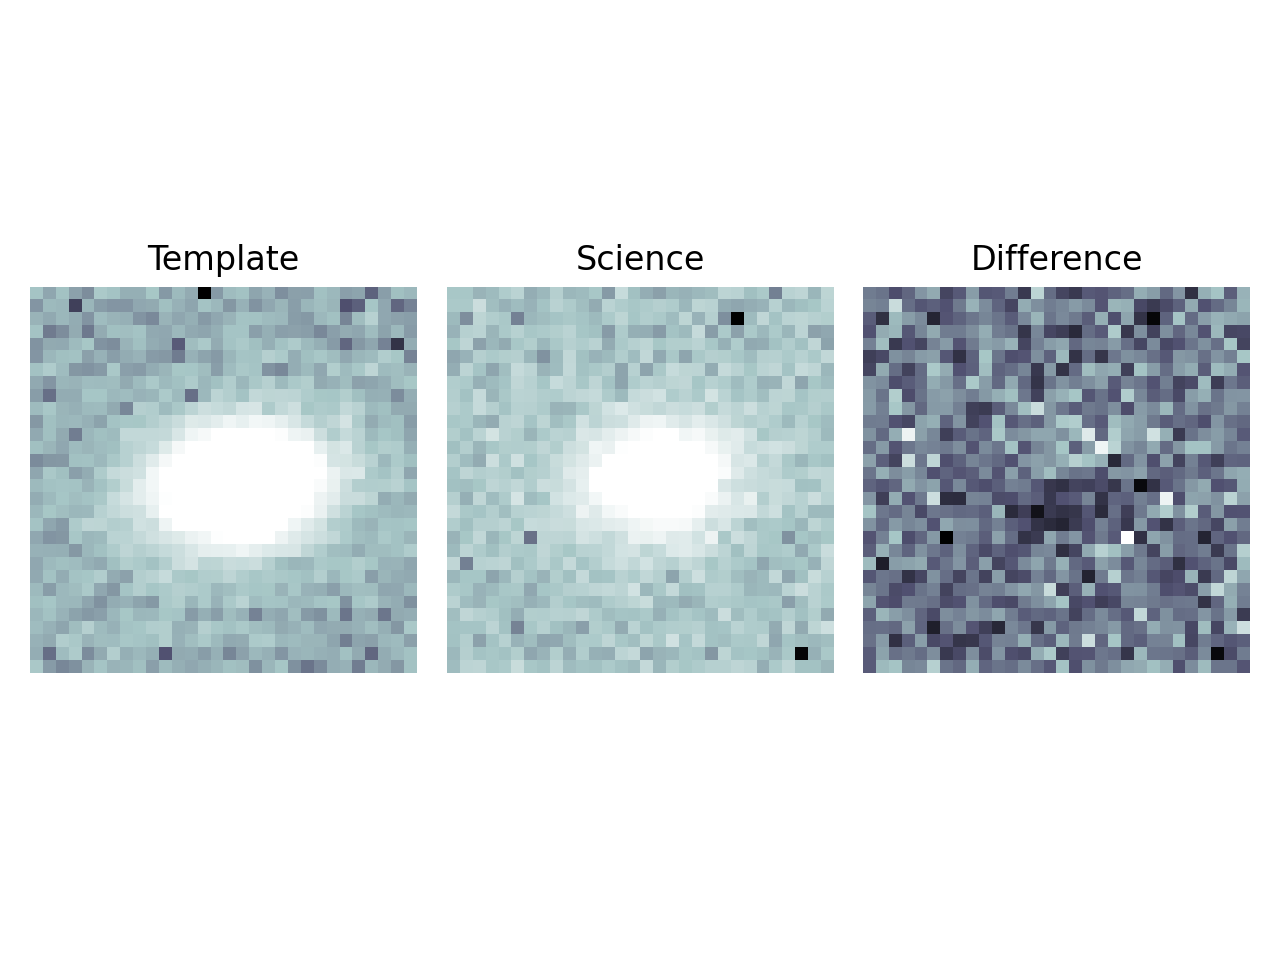

<IPython.core.display.Javascript object>


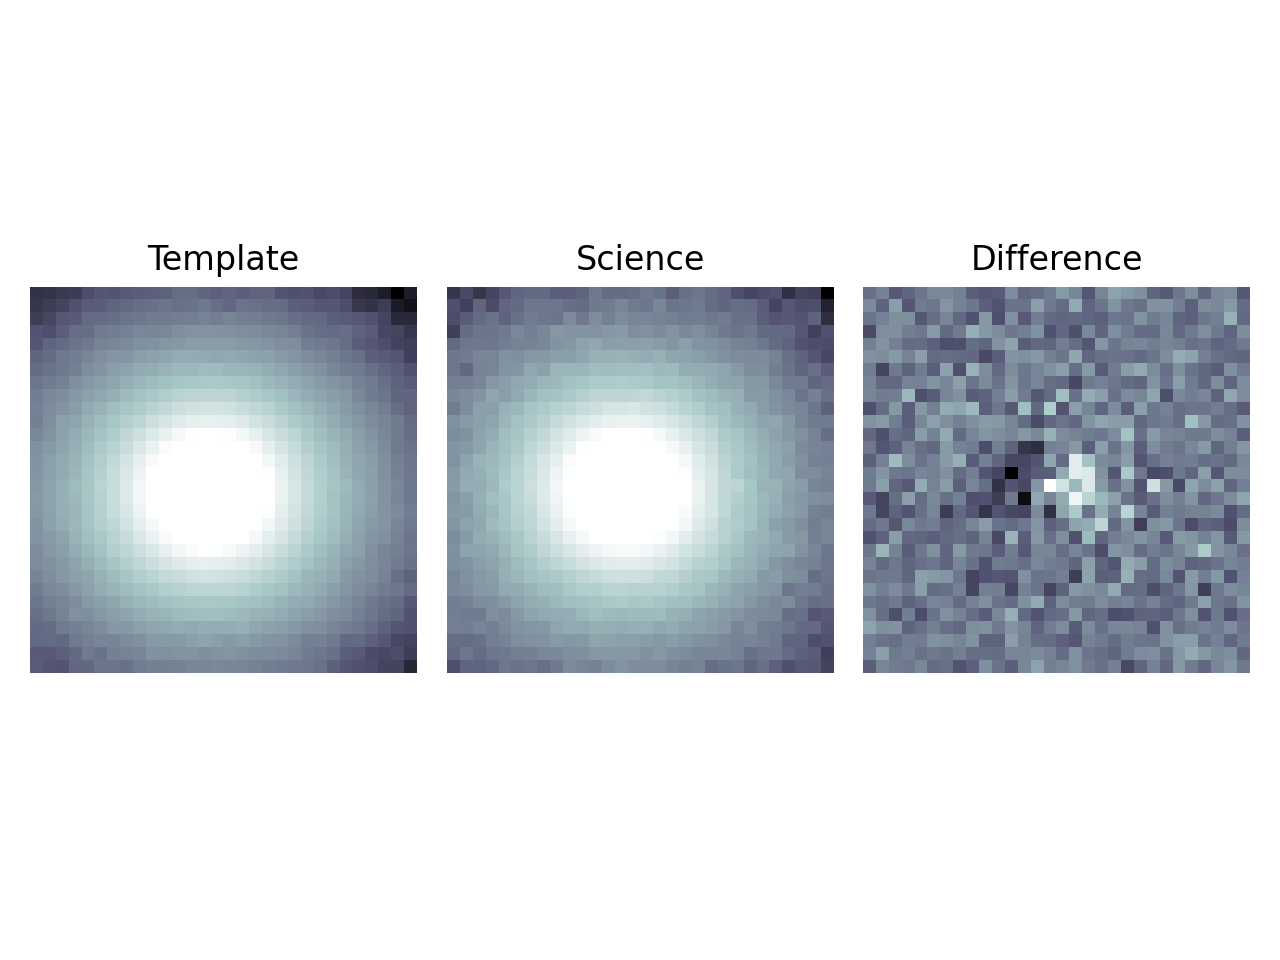

<IPython.core.display.Javascript object>


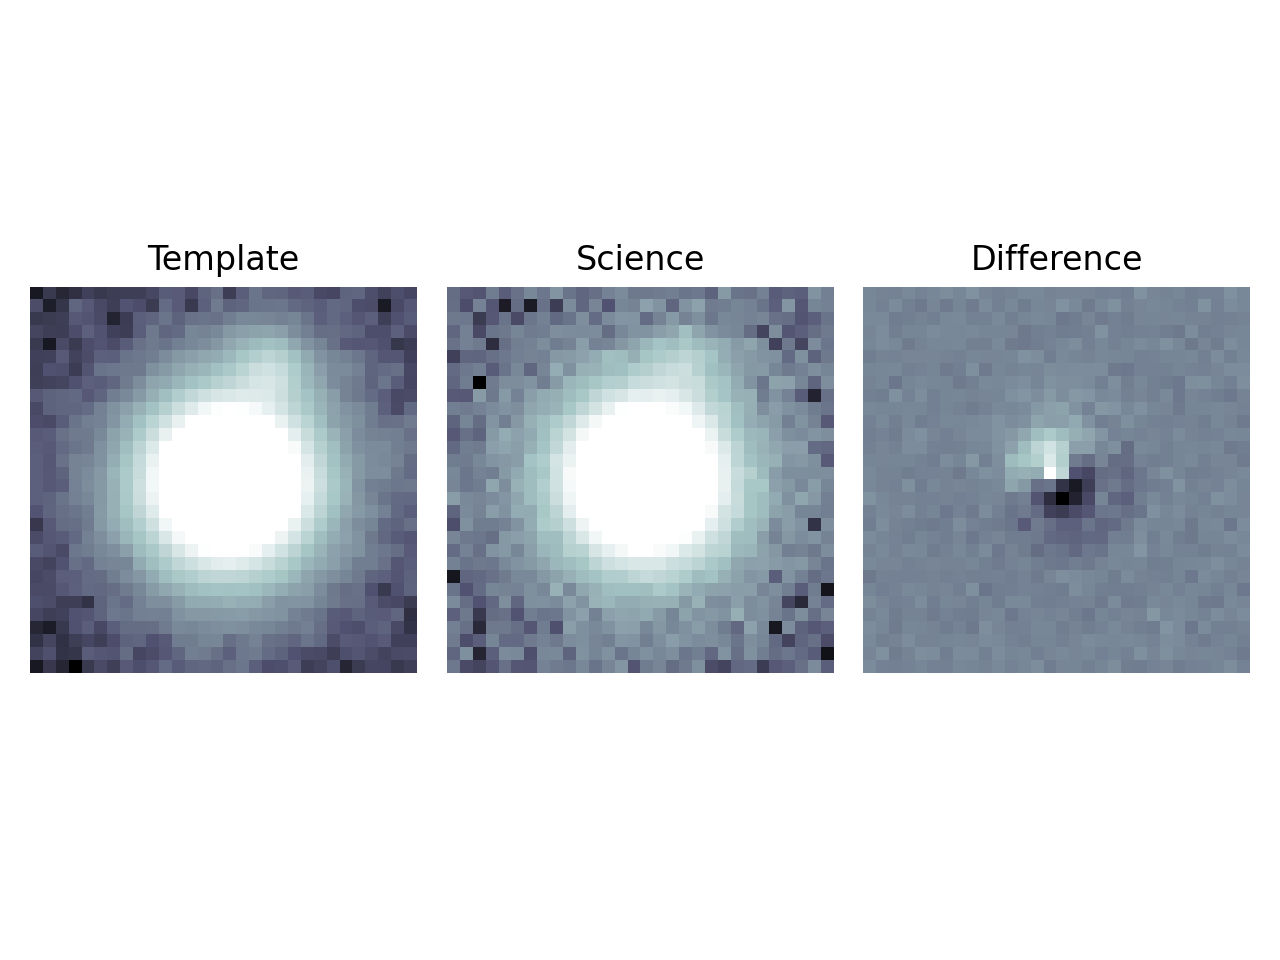

In [23]:
#output_path = "/project/mrawls/diffim_sprint_2021/cutouts-DM28555"
for index, source in goodSrc2[:10].iterrows():
    dataId = {'detector': int(goodSrc2['ccd'][index]), 'visit': int(goodSrc2['visit'][index]), 'instrument': 'HSC'}
    center = lsst.geom.SpherePoint(goodSrc2['ra'][index], goodSrc2['decl'][index], lsst.geom.degrees)
    filename = f"{source['diaSourceId']}.png"
    scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, dataId, collections_DM28555, center)
    plc.plotCutout(scienceCutout, differenceCutout, templateCutout)#, output=os.path.join(output_path, filename))